In [42]:
import DGM
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

# Set the font to Times New Roman for the whole plot
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

# Disable eager execution to use TensorFlow 1.x functions
tf.compat.v1.disable_eager_execution()

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

def terminal_condition(y1, delta_a, delta_b, kappa_1, alpha_1, zeta, hat_y_1):
    ''' Compute the terminal condition for the PDE
    Args:
        y1: wealth
        delta_a: delta parameter a
        delta_b: delta parameter b
    '''
    return tf.exp(- (kappa_1 * alpha_1 / zeta) * (y1 - hat_y_1)**2)

def sampler(nSim_interior, nSim_terminal, t_low, t_high, y_low, y_high, delta_a_low, delta_a_high, delta_b_low, delta_b_high, T):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain and at the terminal time.

    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    '''
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=t_high, size=[nSim_interior, 1])
    y_interior = np.random.uniform(low=y_low, high=y_high, size=[nSim_interior, 1])
    delta_a_interior = np.random.uniform(low=delta_a_low, high=delta_a_high, size=[nSim_interior, 1])
    delta_b_interior = np.random.uniform(low=delta_b_low, high=delta_b_high, size=[nSim_interior, 1])

    # Sampler #2: terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    y_terminal = np.random.uniform(low=y_low, high=y_high, size=[nSim_terminal, 1])
    delta_a_terminal = np.random.uniform(low=delta_a_low, high=delta_a_high, size=[nSim_terminal, 1])
    delta_b_terminal = np.random.uniform(low=delta_b_low, high=delta_b_high, size=[nSim_terminal, 1])

    return t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal

def compute_loss(model, t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal, phi_1, alpha_1, kappa_1, zeta, hat_y_1, theta_2_a, mu_2_a, sigma_2_a, theta_2_b, mu_2_b, sigma_2_b, lambda_a, lambda_b, overline_y_1, underline_y_1):
    ''' Compute total loss for training.

    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        y_interior: sampled space points in the interior of the function's domain
        delta_a_interior: sampled delta a points in the interior of the function's domain
        delta_b_interior: sampled delta b points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        y_terminal: sampled space points at terminal time
        delta_a_terminal: sampled delta a points at terminal time
        delta_b_terminal: sampled delta b points at terminal time
    '''

    # Loss term #1: PDE
    # Compute function value and derivatives at current sampled points
    W = model((t_interior, y_interior, delta_a_interior, delta_b_interior))
    W_t = tf.gradients(W, t_interior)[0]
    W_y = tf.gradients(W, y_interior)[0]
    W_delta_a = tf.gradients(W, delta_a_interior)[0]
    W_delta_b = tf.gradients(W, delta_b_interior)[0]
    W_yy = tf.gradients(W_y, y_interior)[0]
    W_delta_aa = tf.gradients(W_delta_a, delta_a_interior)[0]
    W_delta_bb = tf.gradients(W_delta_b, delta_b_interior)[0]

    # Evaluate W at shifted y values
    W_y_plus_zeta = model((t_interior, y_interior + zeta, delta_a_interior, delta_b_interior))
    W_y_minus_zeta = model((t_interior, y_interior - zeta, delta_a_interior, delta_b_interior))

    # PDE residuals
    diff_W = (2 * W * W_t
              - (2 * phi_1 * kappa_1 / zeta) * (y_interior - hat_y_1)**2 * W**2
              + 2 * theta_2_a * (mu_2_a - delta_a_interior) * W * W_delta_a
              - (sigma_2_a)**2 * W_delta_a**2
              + (sigma_2_a)**2 * W * W_delta_aa
              + 2 * theta_2_b * (mu_2_b - delta_b_interior) * W * W_delta_b
              - (sigma_2_b)**2 * W_delta_b**2
              + (sigma_2_b)**2 * W * W_delta_bb
              + lambda_b * tf.exp(kappa_1 * delta_b_interior - 1) * W_y_plus_zeta**2 * tf.cast(y_interior + zeta <= overline_y_1, tf.float32)
              + lambda_a * tf.exp(kappa_1 * delta_a_interior - 1) * W_y_minus_zeta**2 * tf.cast(y_interior - zeta >= underline_y_1, tf.float32)
             )

    # Compute average L2-norm of differential operator
    L1 = tf.reduce_mean(tf.square(diff_W))

    # Loss term #2: terminal condition
    target_terminal = terminal_condition(y_terminal, delta_a_terminal, delta_b_terminal, kappa_1, alpha_1, zeta, hat_y_1)
    fitted_terminal = model((t_terminal, y_terminal, delta_a_terminal, delta_b_terminal))

    L3 = tf.reduce_mean(tf.square(fitted_terminal - target_terminal))

    return L1, L3

def solve_pde(phi_1=1e-5, kappa_1=10, zeta=1, theta_2_a=10, mu_2_a=0, sigma_2_a=0.02,
              theta_2_b=10, mu_2_b=0, sigma_2_b=0.02, lambda_a=1, lambda_b=1,
              alpha_1=1e-3, hat_y_1=0, overline_y_1=3, underline_y_1=-3,
              T=1, t_low=1e-10, t_high=1, y_low=-3, y_high=3,
              delta_a_low=-0.2, delta_a_high=0.2, delta_b_low=-0.2, delta_b_high=0.2,
              num_layers=3, nodes_per_layer=50, starting_learning_rate=0.001,
              sampling_stages=300, steps_per_sample=25, nSim_interior=1000, nSim_terminal=100,
              saveOutput=False, saveName='CustomPDE', saveFigure=False, figureName='CustomPDE'):

    # Initialize DGM model (last input: space dimension = 3)
    model = DGM.DGMNet(nodes_per_layer, num_layers, 3)

    # Tensor placeholders (_tnsr suffix indicates tensors)
    # Inputs (time, space domain interior, space domain at initial time)
    t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    y_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_a_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_b_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    y_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_a_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])
    delta_b_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None, 1])

    # Loss
    L1_tnsr, L3_tnsr = compute_loss(model, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, t_terminal_tnsr, y_terminal_tnsr, delta_a_terminal_tnsr, delta_b_terminal_tnsr, phi_1, alpha_1, kappa_1, zeta, hat_y_1, theta_2_a, mu_2_a, sigma_2_a, theta_2_b, mu_2_b, sigma_2_b, lambda_a, lambda_b, overline_y_1, underline_y_1)
    loss_tnsr = L1_tnsr + L3_tnsr

    # Value function
    W = model((t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr))

    # Set optimizer
    global_step = tf.compat.v1.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

    # Initialize variables
    init_op = tf.compat.v1.global_variables_initializer()

    # Open session
    sess = tf.compat.v1.Session()
    sess.run(init_op)

    # Train network
    # Initialize loss per training
    loss_list = []

    # For each sampling stage
    for i in range(sampling_stages):
        # Sample uniformly from the required regions
        t_interior, y_interior, delta_a_interior, delta_b_interior, t_terminal, y_terminal, delta_a_terminal, delta_b_terminal = sampler(nSim_interior, nSim_terminal, t_low, t_high, y_low, y_high, delta_a_low, delta_a_high, delta_b_low, delta_b_high, T)

        # For a given sample, take the required number of SGD steps
        for _ in range(steps_per_sample):
            loss_val, L1, L3, _ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                    feed_dict = {t_interior_tnsr: t_interior, y_interior_tnsr: y_interior, delta_a_interior_tnsr: delta_a_interior, delta_b_interior_tnsr: delta_b_interior, t_terminal_tnsr: t_terminal, y_terminal_tnsr: y_terminal, delta_a_terminal_tnsr: delta_a_terminal, delta_b_terminal_tnsr: delta_b_terminal})
            loss_list.append(loss_val)

        print(loss_val, L1, L3, i)

    # Save output
    if saveOutput:
        saver = tf.compat.v1.train.Saver()
        saver.save(sess, './SavedNets/' + saveName)

    return model, sess, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W

In [43]:
#%% Define the h, H, delta functions

def h(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute h based on w"""
    # Sample test points
    t_test = np.array([[t]])
    y_test = np.array([[y]])
    delta_a_test = np.array([[delta_a]])
    delta_b_test = np.array([[delta_b]])

    # Evaluate the model at test points
    w = sess.run(W, feed_dict={t_interior_tnsr: t_test, y_interior_tnsr: y_test, delta_a_interior_tnsr: delta_a_test, delta_b_interior_tnsr: delta_b_test})
    return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation

def H(t, x, y, z, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute H based on h and w"""
    h_val = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    return x + y * z + h_val

def delta_b_star(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute delta_b_star based on h"""
    h_1st = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    h_2nd = h(t, y + zeta, zeta, kappa_1, delta_a, delta_b, sess)
    return (1 / (2 * kappa_1)) + (h_1st / zeta) - (h_2nd / zeta)

def delta_a_star(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    """Compute delta_a_star based on h"""
    h_1st = h(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    h_2nd = h(t, y - zeta, zeta, kappa_1, delta_a, delta_b, sess)
    return (1 / (2 * kappa_1)) + (h_1st / zeta) - (h_2nd / zeta)

def optimal_controls(t, y, zeta, kappa_1, delta_a, delta_b, sess):
    delta_a_star_x=delta_a_star(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    delta_b_star_x=delta_b_star(t, y, zeta, kappa_1, delta_a, delta_b, sess)
    return delta_a_star_x,delta_b_star_x

In [44]:
# Function to simulate an OU process
def simulate_ou_process(theta, mu, sigma, dt, T, initial_value):
    n_steps = int(T / dt)
    delta = np.zeros(n_steps)
    delta[0] = initial_value

    for t in range(1, n_steps):
        delta[t] = delta[t-1] + theta * (mu - delta[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return delta

# Function to simulate correlated OU processes
def simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho):
    n_steps = int(T / dt)
    delta_a = np.zeros(n_steps)
    delta_b = np.zeros(n_steps)
    delta_a[0] = initial_value_a
    delta_b[0] = initial_value_b

    # Generate independent standard normal random variables
    Z1 = np.random.normal(size=n_steps)
    Z2 = np.random.normal(size=n_steps)

    # Create correlated random variables using Cholesky decomposition
    L = np.array([[1, 0], [rho, np.sqrt(1 - rho**2)]])
    correlated_randomness = L @ np.array([Z1, Z2])

    for t in range(1, n_steps):
        delta_a[t] = delta_a[t-1] + theta_a * (mu_a - delta_a[t-1]) * dt + sigma_a * np.sqrt(dt) * correlated_randomness[0, t-1]
        delta_b[t] = delta_b[t-1] + theta_b * (mu_b - delta_b[t-1]) * dt + sigma_b * np.sqrt(dt) * correlated_randomness[1, t-1]
    return delta_a, delta_b

In [4]:
# Simulation parameters
dt = 0.01  # Time step
T = 1  # Total time
n_points = int(T / dt)  # Number of points
time_points = np.linspace(0, T, n_points)

# Case 1
theta_a, mu_a, sigma_a = 10, 0, 0.02
theta_b, mu_b, sigma_b = 10, 0, 0.02
initial_value_a, initial_value_b = 0, 0
delta_a_simulation = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Case 2
theta_a, mu_a, sigma_a = 2, 0, 0.02
theta_b, mu_b, sigma_b = 2, 0, 0.02
delta_a_simulation_2 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_2 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Case 3
theta_a, mu_a, sigma_a = 10, 0, 0.2
theta_b, mu_b, sigma_b = 10, 0, 0.2
delta_a_simulation_3 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_3 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Case 4
theta_a, mu_a, sigma_a = 10, 0.2, 0.02
theta_b, mu_b, sigma_b = 10, 0.2, 0.02
initial_value_a, initial_value_b = 0.5, 0.5
delta_a_simulation_4 = simulate_ou_process(theta_a, mu_a, sigma_a, dt, T, initial_value_a)
delta_b_simulation_4 = simulate_ou_process(theta_b, mu_b, sigma_b, dt, T, initial_value_b)

# Case 5 (Correlated)
theta_a, mu_a, sigma_a = 10, 0, 0.02
theta_b, mu_b, sigma_b = 10, 0, 0.02
initial_value_a, initial_value_b = 0, 0
rho = 1  # Correlation coefficient
delta_a_simulation_5, delta_b_simulation_5 = simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho)

# Case 6 (Correlated)
theta_a, mu_a, sigma_a = 10, 0, 0.02
theta_b, mu_b, sigma_b = 10, 0.05, 0.02
initial_value_a, initial_value_b = 0, 0
rho = 1  # Correlation coefficient
delta_a_simulation_6, delta_b_simulation_6 = simulate_correlated_ou_processes(theta_a, mu_a, sigma_a, theta_b, mu_b, sigma_b, dt, T, initial_value_a, initial_value_b, rho)

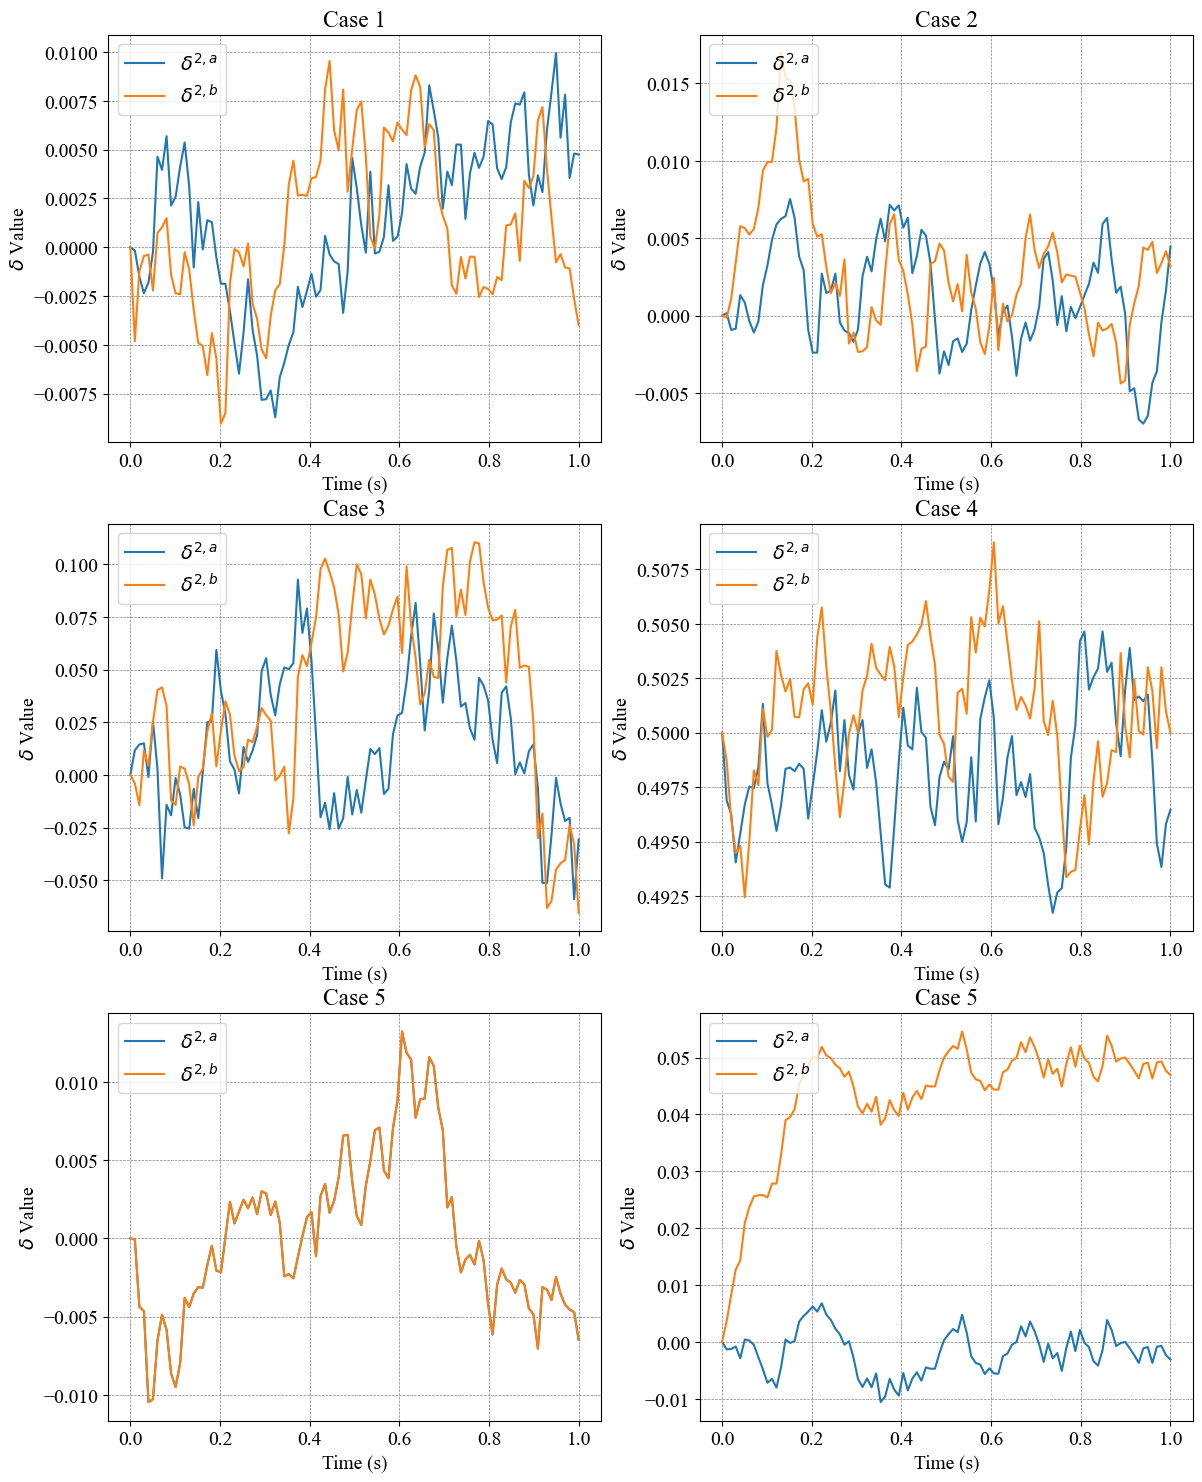

In [50]:
# Update font properties
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

fig, axs = plt.subplots(3, 2, figsize=(14, 18))
axs[0, 0].plot(time_points, delta_a_simulation, label=r'$\delta^{2,a}$')
axs[0, 0].plot(time_points, delta_b_simulation, label=r'$\delta^{2,b}$')
axs[0, 0].set_title('Case 1')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel(r'$\delta$ Value')
axs[0, 0].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[0, 0].tick_params(axis='x', which='both', bottom=True, top=False)
axs[0, 0].tick_params(axis='y', which='both', left=True, right=False)
axs[0, 0].legend(loc='upper left')

axs[0, 1].plot(time_points, delta_a_simulation_2, label=r'$\delta^{2,a}$')
axs[0, 1].plot(time_points, delta_b_simulation_2, label=r'$\delta^{2,b}$')
axs[0, 1].set_title('Case 2')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel(r'$\delta$ Value')
axs[0, 1].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[0, 1].tick_params(axis='x', which='both', bottom=True, top=False)
axs[0, 1].tick_params(axis='y', which='both', left=True, right=False)
axs[0, 1].legend(loc='upper left')

axs[1, 0].plot(time_points, delta_a_simulation_3, label=r'$\delta^{2,a}$')
axs[1, 0].plot(time_points, delta_b_simulation_3, label=r'$\delta^{2,b}$')
axs[1, 0].set_title('Case 3')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel(r'$\delta$ Value')
axs[1, 0].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[1, 0].tick_params(axis='x', which='both', bottom=True, top=False)
axs[1, 0].tick_params(axis='y', which='both', left=True, right=False)
axs[1, 0].legend(loc='upper left')

axs[1, 1].plot(time_points, delta_a_simulation_4, label=r'$\delta^{2,a}$')
axs[1, 1].plot(time_points, delta_b_simulation_4, label=r'$\delta^{2,b}$')
axs[1, 1].set_title('Case 4')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel(r'$\delta$ Value')
axs[1, 1].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[1, 1].tick_params(axis='x', which='both', bottom=True, top=False)
axs[1, 1].tick_params(axis='y', which='both', left=True, right=False)
axs[1, 1].legend(loc='upper left')

axs[2, 0].plot(time_points, delta_a_simulation_5, label=r'$\delta^{2,a}$')
axs[2, 0].plot(time_points, delta_b_simulation_5, label=r'$\delta^{2,b}$')
axs[2, 0].set_title('Case 5')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel(r'$\delta$ Value')
axs[2, 0].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[2, 0].tick_params(axis='x', which='both', bottom=True, top=False)
axs[2, 0].tick_params(axis='y', which='both', left=True, right=False)
axs[2, 0].legend(loc='upper left')

axs[2, 1].plot(time_points, delta_a_simulation_6, label=r'$\delta^{2,a}$')
axs[2, 1].plot(time_points, delta_b_simulation_6, label=r'$\delta^{2,b}$')
axs[2, 1].set_title('Case 5')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel(r'$\delta$ Value')
axs[2, 1].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[2, 1].tick_params(axis='x', which='both', bottom=True, top=False)
axs[2, 1].tick_params(axis='y', which='both', left=True, right=False)
axs[2, 1].legend(loc='upper left')

plt.savefig('Simulated OU process.png', format='png', dpi=300, bbox_inches='tight')

In [6]:
model, sess_1, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde()
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
kappa_1=10
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_1[i,j], delta_b_star_1[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation[j], delta_b_simulation[j],sess_1)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-06-13 16:21:53.566826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


0.2097818 0.09982043 0.109961376 0
0.07141861 0.05166888 0.019749738 1
0.049480468 0.037355684 0.012124784 2
0.03988828 0.03094658 0.008941701 3
0.03377386 0.026745947 0.0070279157 4
0.03218979 0.025645819 0.00654397 5
0.026630312 0.020441035 0.0061892783 6
0.028003942 0.021391064 0.0066128774 7
0.022986509 0.017716754 0.005269755 8
0.016263979 0.011794249 0.00446973 9
0.02075518 0.015500584 0.005254595 10
0.019059956 0.01405004 0.005009915 11
0.016657634 0.012495208 0.004162426 12
0.01616371 0.012597783 0.003565927 13
0.010764729 0.0077408957 0.0030238333 14
0.014252296 0.010445562 0.0038067333 15
0.011613621 0.008615092 0.002998529 16
0.014398439 0.010279354 0.0041190856 17
0.013014513 0.009529455 0.0034850584 18
0.011829305 0.008324086 0.0035052192 19
0.012472699 0.009308853 0.0031638464 20
0.011178716 0.0077833375 0.0033953786 21
0.014959547 0.010484286 0.004475261 22
0.010528874 0.0074449414 0.0030839324 23
0.012908084 0.009207568 0.0037005157 24
0.013429626 0.009435904 0.00399372

0.0029587415 0.002174345 0.00078439654 199
0.0039409325 0.003171938 0.0007689947 200
0.0020125862 0.0014400003 0.00057258585 201
0.0018952682 0.001290828 0.0006044403 202
0.0023405775 0.0016540478 0.0006865298 203
0.002423912 0.0016975868 0.00072632526 204
0.0024663317 0.001872031 0.0005943007 205
0.0021719804 0.0015086753 0.00066330517 206
0.0025779048 0.0019357319 0.000642173 207
0.0023902422 0.0018120405 0.0005782018 208
0.0023819031 0.0017111399 0.00067076326 209
0.00256131 0.0020102372 0.00055107294 210
0.0016510384 0.0012379923 0.0004130461 211
0.0025734687 0.0018646277 0.000708841 212
0.0026619423 0.0019985014 0.00066344097 213
0.0027301006 0.0020950483 0.0006350523 214
0.0023027854 0.001525769 0.0007770165 215
0.002949165 0.0023783818 0.0005707831 216
0.0026234128 0.0019643025 0.00065911026 217
0.0018778096 0.0013808949 0.00049691467 218
0.002385064 0.0017605601 0.0006245039 219
0.0021188993 0.0015027785 0.00061612076 220
0.0023240019 0.0017697528 0.0005542489 221
0.001911024 0

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/128893588.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_1[i,j], delta_b_star_1[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation[j], delta_b_simulation[j],sess_1)


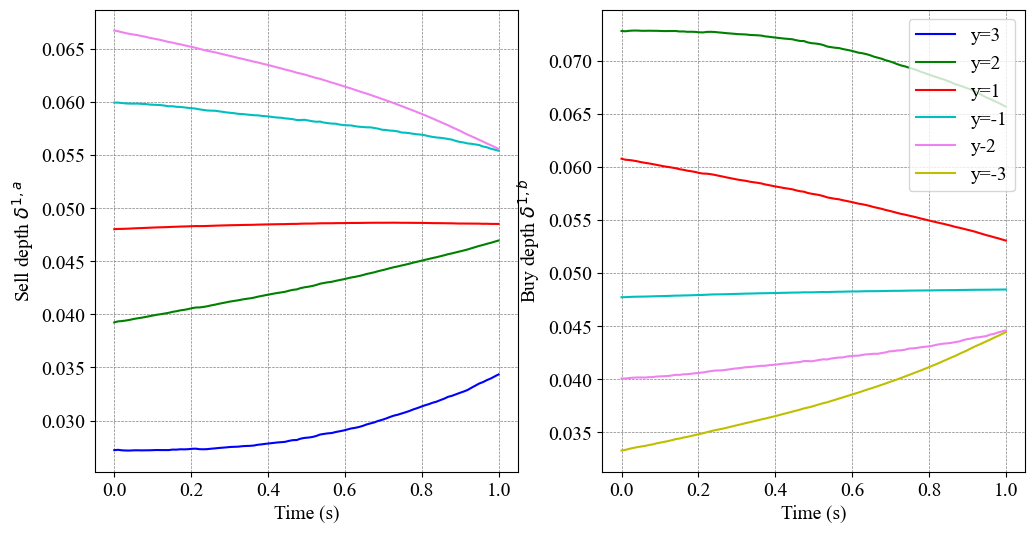

In [7]:
plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.xlabel('Time (s)')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

In [8]:
model, sess_2, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=2, mu_2_a=0, sigma_2_a=0.02, theta_2_b=2, mu_2_b=0, sigma_2_b=0.02)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


0.43659958 0.24947846 0.18712112 0
0.37123314 0.1127916 0.25844154 1
0.2988377 0.09982663 0.19901107 2
0.3008924 0.10095927 0.19993314 3
0.301773 0.10077379 0.20099922 4
0.26241845 0.09093643 0.17148201 5
0.22579896 0.08399612 0.14180285 6
0.23108399 0.084375374 0.14670861 7
0.18702534 0.07495111 0.112074226 8
0.184731 0.073089465 0.11164154 9
0.14604571 0.06553821 0.080507495 10
0.10039193 0.054264802 0.04612713 11
0.11070748 0.05618521 0.054522265 12
0.087773725 0.051935744 0.035837978 13
0.07112604 0.04375853 0.027367508 14
0.07775324 0.0466575 0.031095741 15
0.06195262 0.042007174 0.019945448 16
0.05207406 0.035360117 0.016713941 17
0.041701026 0.028015628 0.013685397 18
0.038798854 0.027239352 0.0115595 19
0.036148805 0.024487054 0.01166175 20
0.030715639 0.021771505 0.008944133 21
0.035333782 0.025546325 0.009787457 22
0.030708255 0.021001233 0.009707022 23
0.02571201 0.017284391 0.008427619 24
0.01921883 0.014316531 0.004902299 25
0.02033237 0.0142873 0.0060450686 26
0.018423425

0.0068564857 0.0049963584 0.0018601274 203
0.0045011947 0.0034404902 0.0010607047 204
0.0056475885 0.0040955315 0.001552057 205
0.0059627416 0.004313882 0.0016488596 206
0.0059725726 0.004311634 0.0016609386 207
0.00537816 0.004417436 0.00096072414 208
0.0048837056 0.0037815818 0.0011021238 209
0.007569792 0.00592492 0.001644872 210
0.004597413 0.0031973077 0.0014001051 211
0.0076395236 0.0056283884 0.002011135 212
0.008325921 0.006078215 0.0022477068 213
0.004107262 0.0030820947 0.0010251671 214
0.0041232174 0.002867955 0.0012552626 215
0.0045439727 0.003243906 0.0013000666 216
0.0046261363 0.003182252 0.0014438841 217
0.0041518025 0.0030511618 0.0011006405 218
0.0034071153 0.0026437035 0.0007634118 219
0.0049362252 0.0031754875 0.0017607376 220
0.0057709655 0.004457223 0.0013137424 221
0.0044937097 0.0032501456 0.0012435638 222
0.0037594237 0.0029009518 0.00085847196 223
0.0047543235 0.0030773936 0.0016769299 224
0.0050705606 0.0034833709 0.0015871899 225
0.0026190942 0.0021210536 0.

In [9]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_2 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_2[i,j], delta_b_star_2[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_2[j], delta_b_simulation_2[j],sess_2)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/2978212112.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_2[i,j], delta_b_star_2[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_2[j], delta_b_simulation_2[j],sess_2)


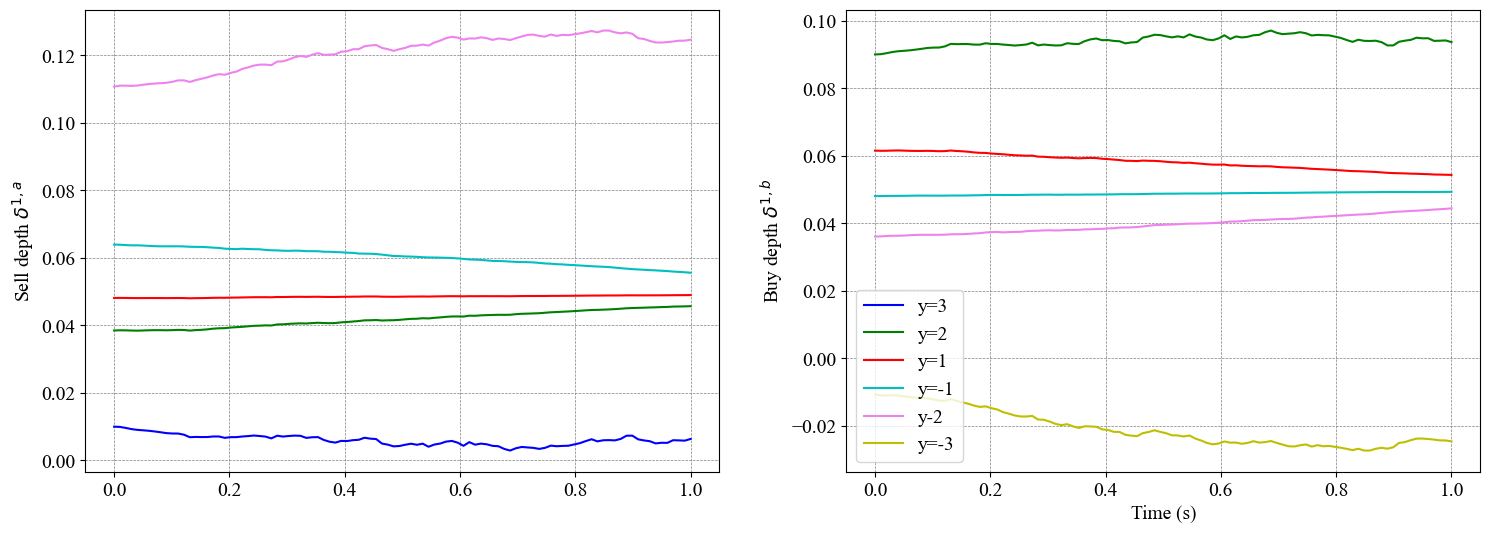

In [10]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_2[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_2[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_2[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_2[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_2[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_2[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_2[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


In [11]:
model, sess_3, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.2, theta_2_b=10, mu_2_b=0, sigma_2_b=0.2)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


0.27460712 0.10031339 0.17429374 0
0.11595808 0.056436248 0.05952183 1
0.07089816 0.044145882 0.026752282 2
0.052624352 0.03676801 0.015856339 3
0.039283767 0.03129991 0.007983858 4
0.041786607 0.032130077 0.00965653 5
0.03562356 0.027266428 0.008357134 6
0.0384459 0.029378887 0.009067015 7
0.035586923 0.028061192 0.0075257327 8
0.034187913 0.026149128 0.008038786 9
0.03341781 0.025639385 0.0077784257 10
0.029902514 0.022941874 0.0069606397 11
0.027500277 0.021621963 0.005878314 12
0.024793146 0.019294651 0.005498495 13
0.022792302 0.017741287 0.0050510145 14
0.020685757 0.015893 0.004792757 15
0.01801717 0.013325504 0.004691664 16
0.015998034 0.011761711 0.0042363233 17
0.015605953 0.012062615 0.0035433373 18
0.014838753 0.01076386 0.0040748925 19
0.01431013 0.010043088 0.0042670416 20
0.014887029 0.010834138 0.004052892 21
0.012300008 0.008868344 0.0034316638 22
0.012964997 0.009053281 0.003911717 23
0.011053634 0.0075435834 0.0035100502 24
0.018976197 0.013437869 0.005538328 25
0.01

0.0026406005 0.0017269545 0.0009136461 201
0.003991833 0.002651786 0.0013400471 202
0.0034638837 0.0023362935 0.0011275902 203
0.0041917795 0.0026849299 0.0015068497 204
0.00567071 0.004412743 0.0012579673 205
0.0045972983 0.0030814572 0.001515841 206
0.004993768 0.003357298 0.00163647 207
0.0037355376 0.0026696026 0.0010659351 208
0.004301353 0.0033769298 0.000924423 209
0.003964512 0.0026317053 0.0013328069 210
0.0048835296 0.0031673056 0.0017162238 211
0.0031878832 0.0020332236 0.0011546597 212
0.0032255119 0.002138761 0.0010867509 213
0.0029327972 0.0018230536 0.0011097437 214
0.0032585673 0.002324573 0.0009339942 215
0.0032711758 0.0021752343 0.0010959415 216
0.0029783759 0.0018204887 0.0011578872 217
0.0023968327 0.0014959014 0.00090093137 218
0.0030534333 0.0018020864 0.0012513468 219
0.003021753 0.0022093554 0.00081239745 220
0.0058577 0.0043822196 0.0014754804 221
0.002569072 0.0016053577 0.0009637143 222
0.002886511 0.0017797529 0.0011067579 223
0.0024474182 0.0014703847 0.00

In [12]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_3 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_3[j], delta_b_simulation_3[j],sess_3)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1494612606.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_3[j], delta_b_simulation_3[j],sess_3)


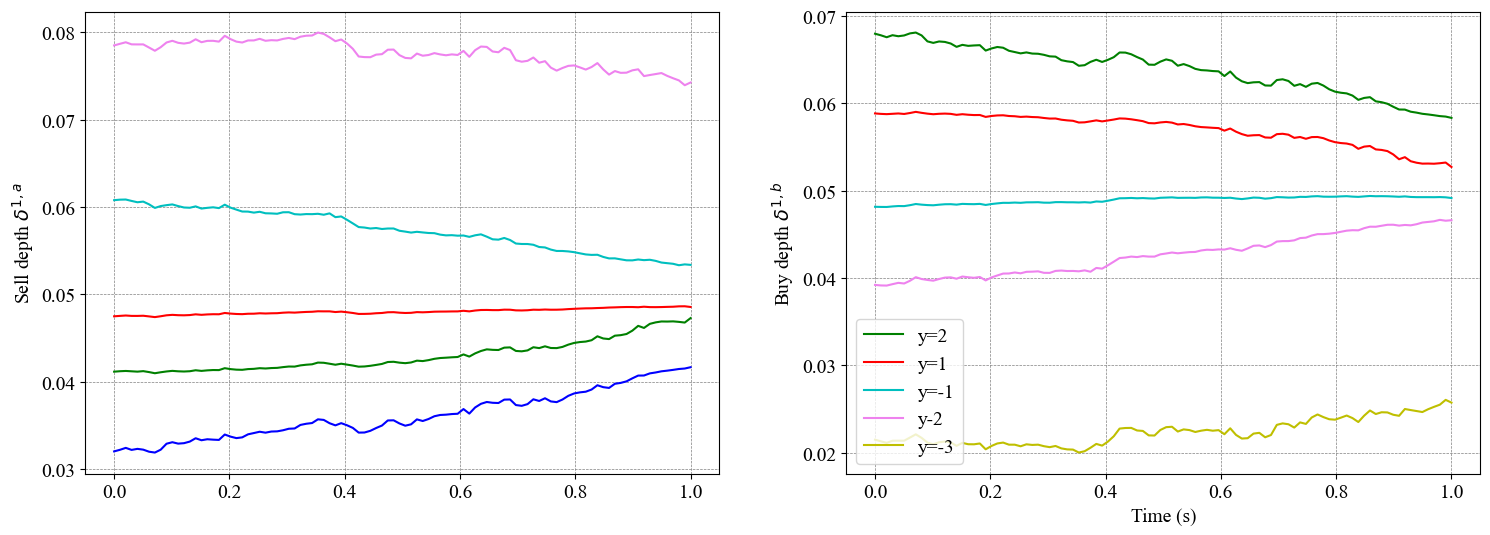

In [15]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_3[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_3[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_3[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_3[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_3[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_3[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_3[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


In [36]:
model, sess_4, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0.2, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0.2, sigma_2_b=0.02)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1.1525013 0.39803955 0.7544618 0
0.35385382 0.20764242 0.1462114 1
0.24472764 0.13622735 0.10850029 2
0.20211807 0.104132965 0.0979851 3
0.16570829 0.09486227 0.07084602 4
0.15309668 0.0854507 0.06764597 5
0.12384776 0.07444103 0.04940673 6
0.10629584 0.069706604 0.036589235 7
0.1095154 0.06991358 0.039601818 8
0.11459246 0.0750941 0.039498366 9
0.09104581 0.059733763 0.03131205 10
0.09514782 0.06385718 0.031290635 11
0.10397497 0.06461626 0.03935871 12
0.08943973 0.056388155 0.033051573 13
0.081911296 0.053640224 0.028271073 14
0.087161705 0.057409268 0.029752433 15
0.0907947 0.05492276 0.035871934 16
0.076316625 0.050844796 0.025471825 17
0.09197143 0.05903533 0.032936096 18
0.07509422 0.047435388 0.027658831 19
0.07623319 0.047644746 0.028588451 20
0.061152354 0.04126236 0.019889994 21
0.07281725 0.04834792 0.024469333 22
0.06983798 0.046028238 0.023809742 23
0.07319218 0.046563238 0.026628945 24
0.077070795 0.048857186 0.02821361 25
0.07645831 0.04690786 0.02955045 26
0.051774718 0

0.005158467 0.0019456577 0.0032128096 205
0.0037193205 0.0017915935 0.0019277269 206
0.023654643 0.021437299 0.0022173452 207
0.005732873 0.0033036305 0.0024292425 208
0.0052582324 0.0018923702 0.0033658624 209
0.0043279785 0.0016650783 0.0026629001 210
0.0071089067 0.0024356572 0.0046732496 211
0.004289812 0.0019491842 0.0023406278 212
0.005735958 0.0025591222 0.003176836 213
0.0053614313 0.0034583346 0.0019030967 214
0.007166215 0.004241074 0.0029251415 215
0.004150501 0.0024990097 0.0016514913 216
0.005821562 0.0042429636 0.0015785983 217
0.003811185 0.0017421122 0.0020690728 218
0.00308253 0.0014546923 0.0016278379 219
0.00257849 0.0011766587 0.0014018312 220
0.0041281013 0.0016076956 0.0025204057 221
0.004108276 0.0012674748 0.0028408014 222
0.004314243 0.0020926474 0.0022215955 223
0.00344725 0.0019071382 0.0015401118 224
0.004476737 0.0019555248 0.0025212127 225
0.013550003 0.009292701 0.004257302 226
0.0041706515 0.0020967154 0.002073936 227
0.005169401 0.0019912047 0.003178196

In [45]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_4 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_4[i,j], delta_b_star_4[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_4[j], delta_b_simulation_4[j],sess_4)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/3262300112.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_4[i,j], delta_b_star_4[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_4[j], delta_b_simulation_4[j],sess_4)


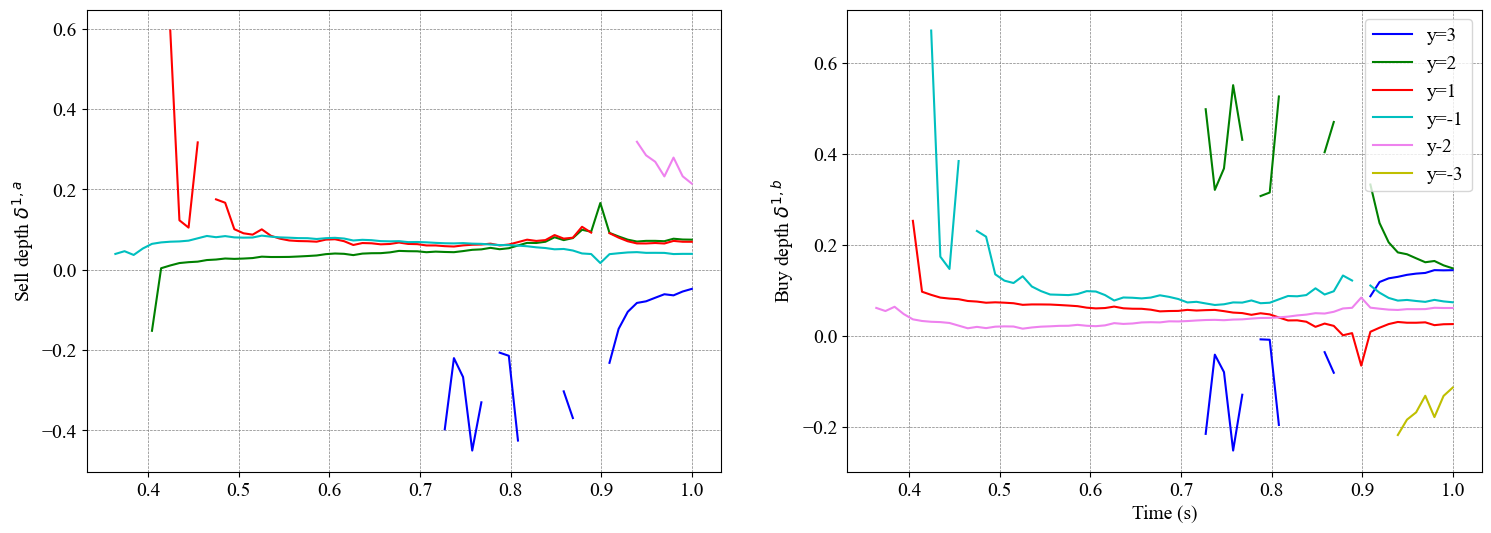

In [46]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_4[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_4[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_4[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_4[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_4[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_4[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_4[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_4[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


In [20]:
model, sess_5, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0, sigma_2_b=0.02)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


0.21421653 0.08195525 0.13226129 0
0.071524076 0.051317804 0.02020627 1
0.04099528 0.032299746 0.008695535 2
0.036640756 0.027911453 0.008729301 3
0.03367549 0.025685504 0.007989989 4
0.030069923 0.023142649 0.0069272737 5
0.024931133 0.01824102 0.006690113 6
0.022315431 0.016683454 0.0056319786 7
0.018378958 0.013795097 0.00458386 8
0.014867325 0.011121626 0.0037456993 9
0.0136769945 0.010015039 0.003661956 10
0.01268205 0.009207892 0.0034741575 11
0.016760884 0.012230491 0.004530393 12
0.0142475255 0.010261627 0.003985898 13
0.012674237 0.0088899555 0.0037842817 14
0.012540022 0.009222223 0.003317798 15
0.011764146 0.008716865 0.0030472807 16
0.009926155 0.006677501 0.0032486543 17
0.0119656455 0.008820873 0.003144773 18
0.011409421 0.008243841 0.00316558 19
0.01154658 0.008423063 0.0031235171 20
0.010852799 0.00802492 0.0028278793 21
0.01080405 0.007888521 0.002915529 22
0.012656729 0.009497769 0.0031589598 23
0.010213041 0.0071381917 0.003074849 24
0.010201069 0.007722147 0.0024789

0.004301035 0.0031347848 0.0011662502 200
0.0026655365 0.0017552383 0.0009102981 201
0.003990824 0.0028867766 0.0011040473 202
0.0128156645 0.01047257 0.0023430947 203
0.0046755774 0.003316982 0.0013585954 204
0.003176704 0.0022313518 0.0009453523 205
0.0021064687 0.0014287657 0.000677703 206
0.0028725266 0.0016797183 0.0011928083 207
0.002180412 0.0013213936 0.0008590184 208
0.0021158303 0.0012811502 0.0008346802 209
0.0019570286 0.0011538677 0.00080316106 210
0.0036620433 0.0023441713 0.0013178721 211
0.0024843495 0.001349044 0.0011353054 212
0.002610059 0.001747325 0.0008627339 213
0.0027828673 0.0017570059 0.0010258615 214
0.0034088325 0.0024973012 0.0009115314 215
0.002515887 0.0015869276 0.0009289592 216
0.0027553826 0.0019188626 0.0008365199 217
0.0021347753 0.0013497131 0.00078506226 218
0.012104965 0.010709766 0.0013951984 219
0.004532015 0.0032512248 0.0012807903 220
0.0025263538 0.0016799629 0.000846391 221
0.0035533374 0.0027257577 0.0008275798 222
0.003758263 0.002408649 0

In [21]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_5 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_5 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_5[i,j], delta_b_star_5[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_5[j], delta_b_simulation_5[j],sess_5)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/2881710901.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_5[i,j], delta_b_star_5[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_5[j], delta_b_simulation_5[j],sess_5)


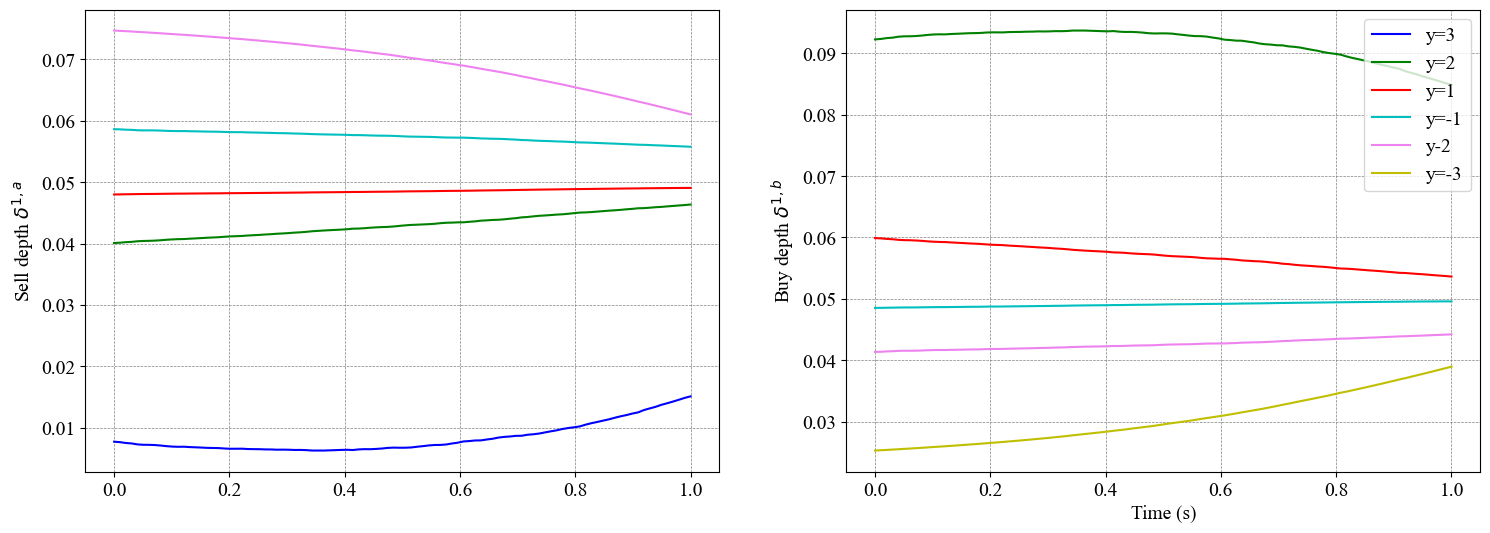

In [22]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_5[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_5[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_5[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_5[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_5[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_5[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_5[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_5[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_5[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_5[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_5[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_5[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks


In [23]:
model, sess_6, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(theta_2_a=10, mu_2_a=0, sigma_2_a=0.02, theta_2_b=10, mu_2_b=0.05, sigma_2_b=0.02)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'dgm_net_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1.7083519 0.5785113 1.1298405 0
0.8105397 0.390737 0.4198027 1
0.50105846 0.22960554 0.2714529 2
0.39515093 0.1517977 0.24335323 3
0.3367259 0.12578847 0.21093743 4
0.3012305 0.116619945 0.18461056 5
0.2658076 0.10773934 0.15806827 6
0.25157666 0.09929076 0.1522859 7
0.21101207 0.09716804 0.11384402 8
0.18943751 0.09589661 0.09354091 9
0.16530454 0.09340002 0.07190452 10
0.12875788 0.07727764 0.051480245 11
0.09000674 0.05797423 0.03203251 12
0.0783997 0.056445695 0.021954006 13
0.057726525 0.04233342 0.015393103 14
0.04924483 0.038958665 0.010286164 15
0.04778392 0.036659878 0.011124042 16
0.044263832 0.03425318 0.010010651 17
0.03657801 0.028757816 0.007820195 18
0.040430434 0.03143494 0.008995494 19
0.03413213 0.026998775 0.0071333563 20
0.03136583 0.02442946 0.0069363713 21
0.03163102 0.025140097 0.0064909207 22
0.0258869 0.021027673 0.0048592268 23
0.026673758 0.021038583 0.0056351763 24
0.024485616 0.018751232 0.0057343836 25
0.023218153 0.018217517 0.0050006364 26
0.022126291 0.

0.0061847726 0.0045567756 0.0016279973 202
0.003868543 0.0024301242 0.0014384189 203
0.004481408 0.0032731397 0.001208268 204
0.0039714845 0.002388138 0.0015833464 205
0.0033266498 0.00207943 0.0012472199 206
0.0026212763 0.0017015343 0.000919742 207
0.0038132058 0.0026037917 0.0012094141 208
0.0034937502 0.002523466 0.0009702843 209
0.0034802887 0.0020614725 0.0014188162 210
0.0036844031 0.002459775 0.0012246282 211
0.0039350204 0.002741542 0.0011934782 212
0.003153012 0.0022827692 0.0008702428 213
0.003067274 0.0019597318 0.0011075423 214
0.004772528 0.0035364977 0.0012360301 215
0.005117014 0.0037950596 0.0013219544 216
0.0029527242 0.0019137413 0.0010389828 217
0.0037194814 0.0025302095 0.0011892719 218
0.009014081 0.0072374414 0.0017766401 219
0.0050432975 0.0038446493 0.0011986484 220
0.0044177547 0.0033213357 0.001096419 221
0.0043019773 0.0030379859 0.0012639916 222
0.0026554556 0.0016145214 0.0010409342 223
0.0035037326 0.0021825668 0.0013211658 224
0.004681295 0.003565699 0.0

In [24]:
time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_6 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_6 = np.zeros((len(y_test_range),len(t_grid)))
zeta=1
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        delta_a_star_6[i,j], delta_b_star_6[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_6[j], delta_b_simulation_6[j],sess_6)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/282891806.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_a_star_6[i,j], delta_b_star_6[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_simulation_6[j], delta_b_simulation_6[j],sess_6)
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_23765/1884657099.py:13: RuntimeWarning: invalid value encountered in log
  return (zeta / kappa_1) * np.log(w)  # Use numpy log here for the final evaluation


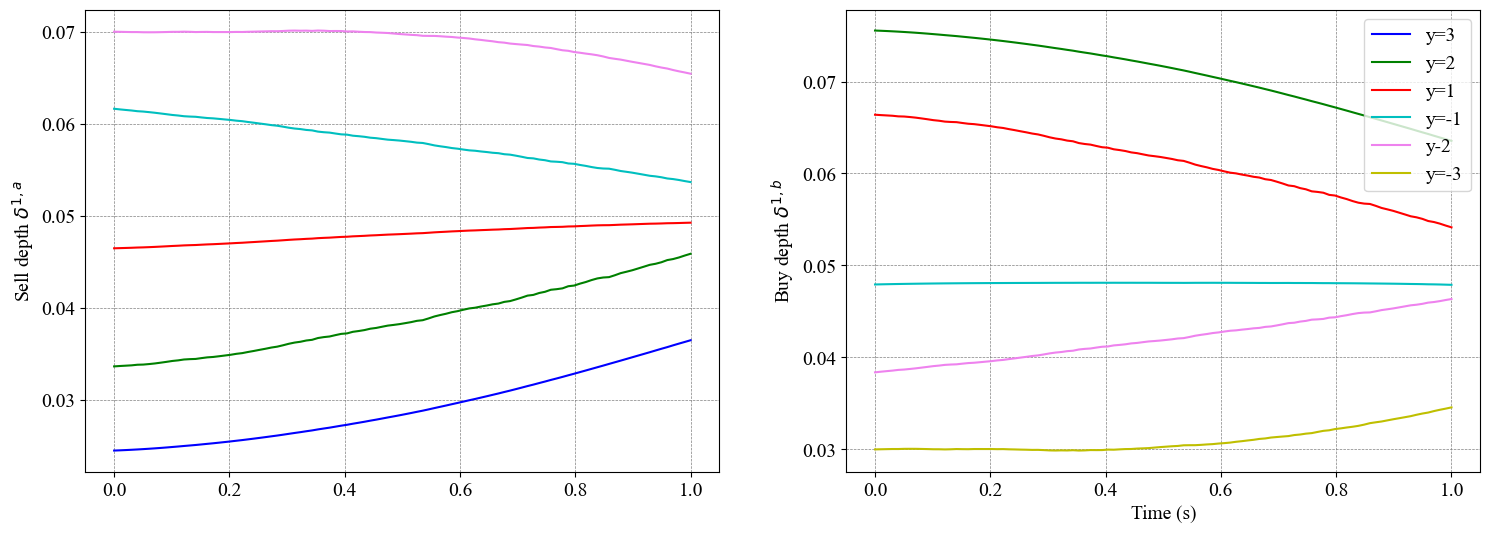

In [26]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot(t_grid,delta_a_star_6[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_6[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_6[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_6[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_6[1,:],'violet',label='$y=-2$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(t_grid,delta_b_star_6[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_6[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_6[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_6[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_6[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_6[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
plt.legend()
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

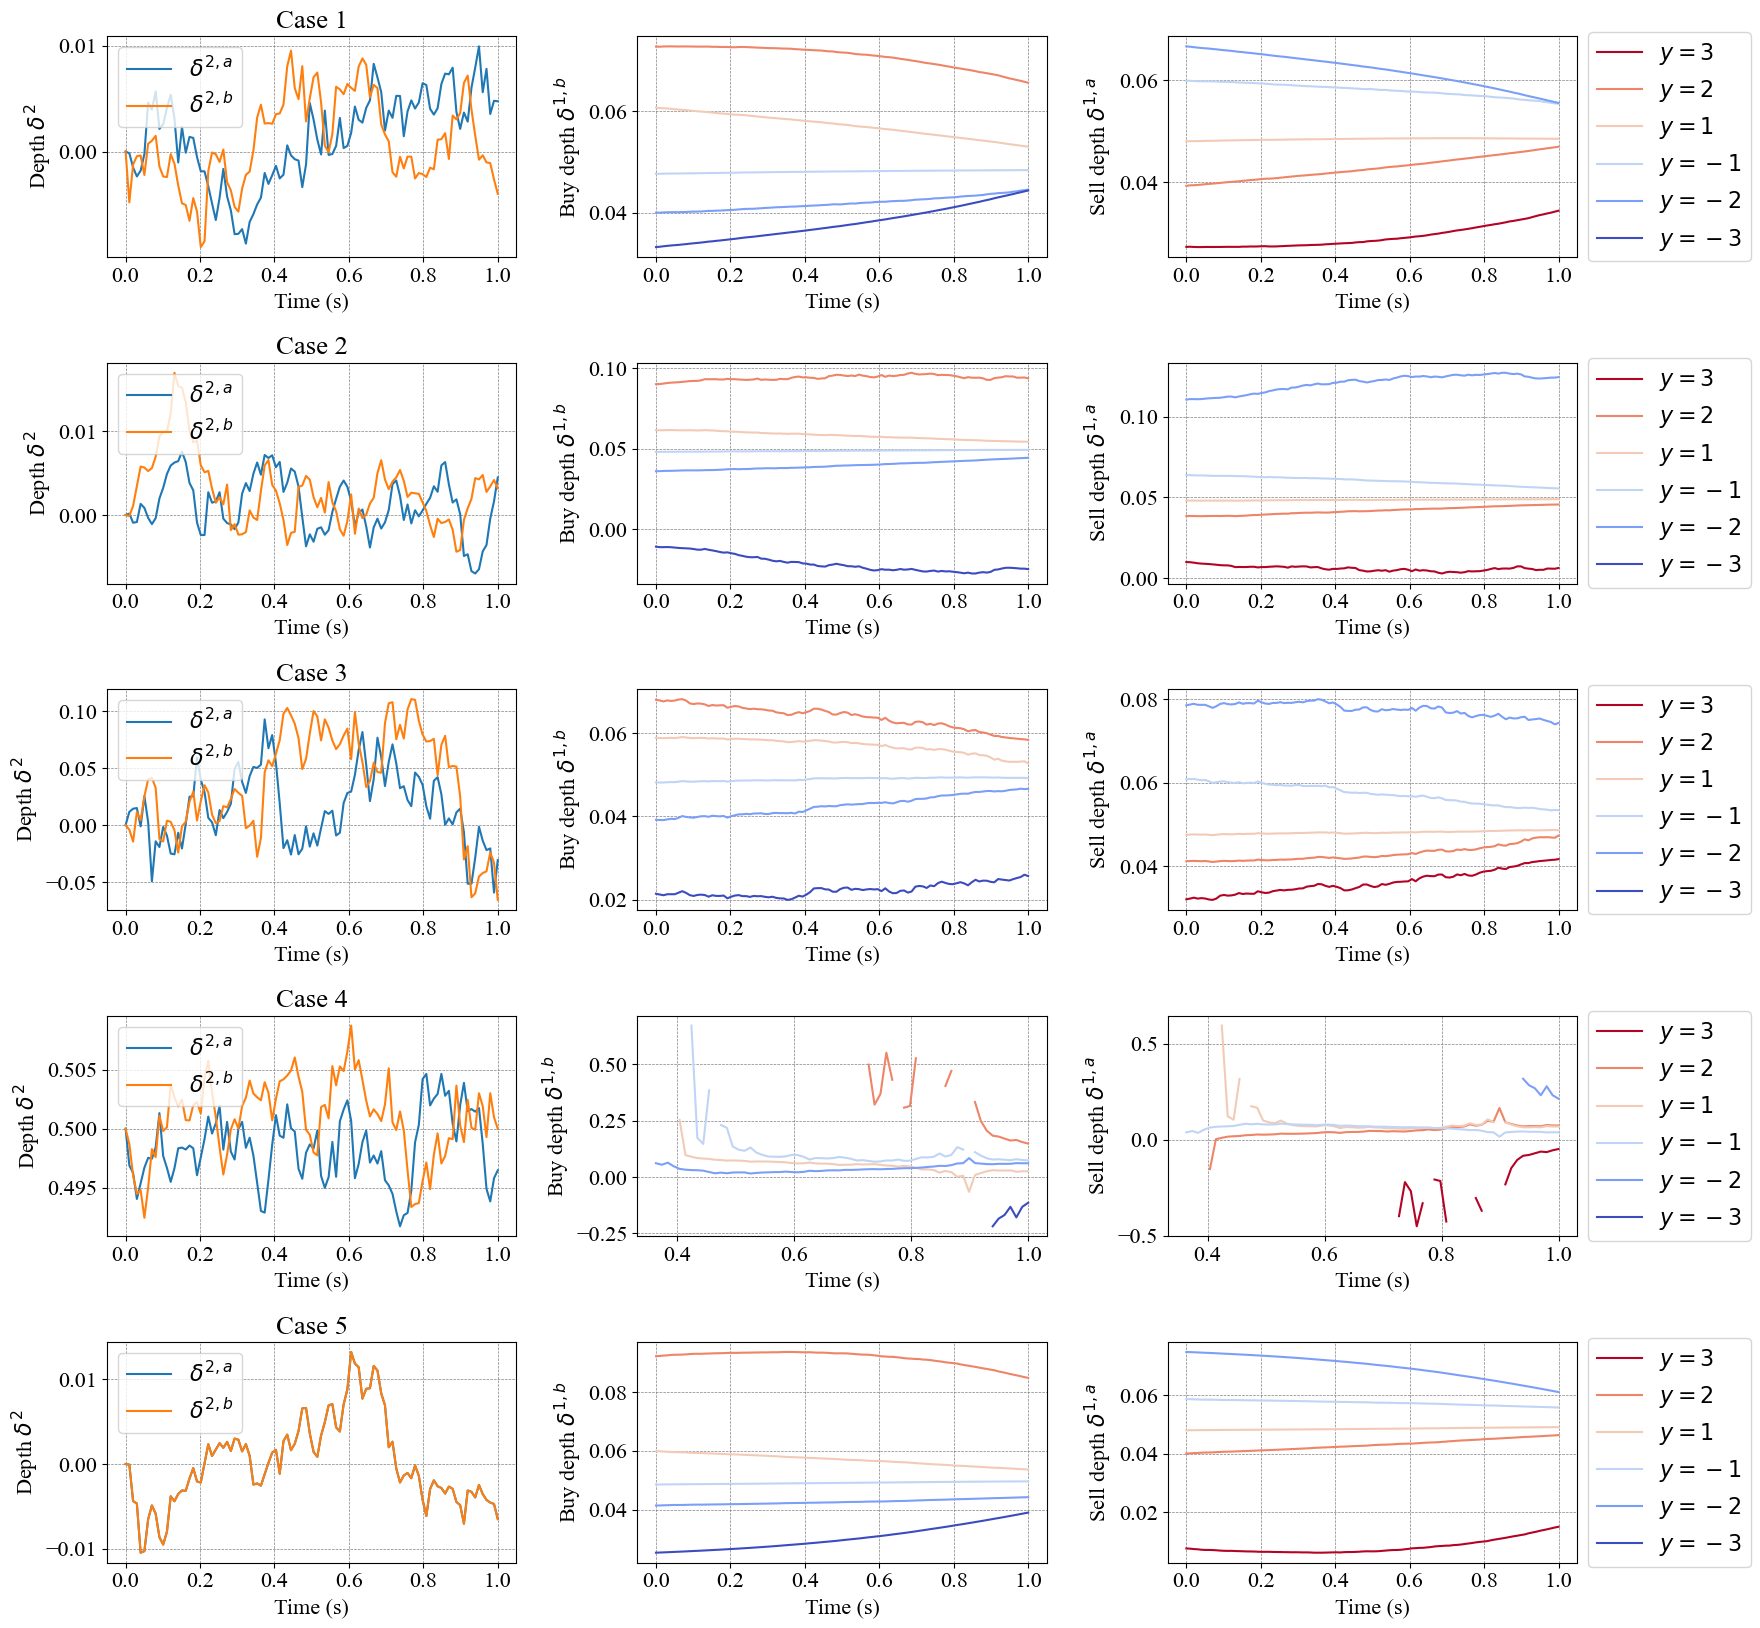

In [56]:
import matplotlib.pyplot as plt

# Assuming time_points, t_grid, delta_a_simulation, delta_b_simulation, 
# delta_a_simulation_2, delta_b_simulation_2, delta_a_simulation_3, delta_b_simulation_3,
# delta_a_simulation_4, delta_b_simulation_4, delta_a_simulation_5, delta_b_simulation_5,
# delta_a_simulation_6, delta_b_simulation_6, delta_a_star_1, delta_b_star_1, delta_a_star_2, delta_b_star_2,
# delta_a_star_3, delta_b_star_3, delta_a_star_4, delta_b_star_4, delta_a_star_5, delta_b_star_5, 
# delta_a_star_6, delta_b_star_6 are already defined

# Update font properties
plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})

# Create a colormap with a range of colors from red to blue
colors = plt.cm.coolwarm(np.linspace(0, 1, 6))

fig, axs = plt.subplots(5, 3, figsize=(18, 18))
# List of cases
simulations = [
    (delta_a_simulation, delta_b_simulation, delta_a_star_1, delta_b_star_1),
    (delta_a_simulation_2, delta_b_simulation_2, delta_a_star_2, delta_b_star_2),
    (delta_a_simulation_3, delta_b_simulation_3, delta_a_star_3, delta_b_star_3),
    (delta_a_simulation_4, delta_b_simulation_4, delta_a_star_4, delta_b_star_4),
    (delta_a_simulation_5, delta_b_simulation_5, delta_a_star_5, delta_b_star_5)
]

# Titles for each row
titles = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6']

# Plotting each case
for i, (delta_a_sim, delta_b_sim, delta_a_star, delta_b_star) in enumerate(simulations):
    # Column 1: OU Process
    axs[i, 0].plot(time_points, delta_a_sim, label=r'$\delta^{2,a}$')
    axs[i, 0].plot(time_points, delta_b_sim, label=r'$\delta^{2,b}$')
    axs[i, 0].set_title(titles[i])
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel(r'Depth $\delta^2$')
    axs[i, 0].grid(True, color='gray', linestyle='--', linewidth=0.5)
    axs[i, 0].legend(loc='upper left')
    
    # Column 2: Buy Depth
    axs[i, 1].plot(t_grid, delta_b_star[4, :], color=colors[4], label='$y=2$')
    axs[i, 1].plot(t_grid, delta_b_star[3, :], color=colors[3], label='$y=1$')
    axs[i, 1].plot(t_grid, delta_b_star[2, :], color=colors[2], label='$y=-1$')
    axs[i, 1].plot(t_grid, delta_b_star[1, :], color=colors[1], label='$y=-2$')
    axs[i, 1].plot(t_grid, delta_b_star[0, :], color=colors[0], label='$y=-3$')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel(r'Buy depth $\delta^{1,b}$')
    axs[i, 1].grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Column 3: Sell Depth
    axs[i, 2].plot(t_grid, delta_a_star[5, :], color=colors[5], label='$y=3$')
    axs[i, 2].plot(t_grid, delta_a_star[4, :], color=colors[4], label='$y=2$')
    axs[i, 2].plot(t_grid, delta_a_star[3, :], color=colors[3], label='$y=1$')
    axs[i, 2].plot(t_grid, delta_a_star[2, :], color=colors[2], label='$y=-1$')
    axs[i, 2].plot(t_grid, delta_a_star[1, :], color=colors[1], label='$y=-2$')
    axs[i, 2].plot(t_grid, delta_a_star[0, :], color=colors[0], label='$y=-3$')
    axs[i, 2].set_xlabel('Time (s)')
    axs[i, 2].set_ylabel(r'Sell depth $\delta^{1,a}$')
    axs[i, 2].grid(True, color='gray', linestyle='--', linewidth=0.5)
    axs[i, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig('Simulated_OU_processes_subplots.png', format='png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [ ]:
phi11 = np.linspace(10**(-1),10**(-5),5) # No inventory penalty
t=t_grid[-1]
delta_a_2=delta_a_simulation[-1];
delta_b_2=delta_b_simulation[-1];
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for j, phi in enumerate(phi11):
  model, sess_2, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(phi_1=phi)
  for i,y_test in enumerate(y_test_range):
    delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_2, delta_b_2,sess_2)

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

In [ ]:
alpha11 = np.linspace(10**(-1),10**(-5),5) # No inventory penalty
t=t_grid[-1]
delta_a_2=delta_a_simulation[-1];
delta_b_2=delta_b_simulation[-1];
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for j, alpha in enumerate(alpha11):
  model, sess_3, t_interior_tnsr, y_interior_tnsr, delta_a_interior_tnsr, delta_b_interior_tnsr, W = solve_pde(alpha_1=phi)
  for i,y_test in enumerate(y_test_range):
    delta_a_star_3[i,j], delta_b_star_3[i,j] = optimal_controls(t, y_test, zeta, kappa_1, delta_a_2, delta_b_2,sess_3)

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,1)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks